# Моделирование цен на недвижимость

Объединяем методы предыдущих занятий в единый конвейер обработки и моделирования данных.

In [34]:
import pandas as pd

data = pd.read_csv('data/processed/nnapartment_more_info_new_features.csv')

In [35]:
X = data.drop('price', axis=1)

In [36]:
y = data.price

In [37]:
X.shape, y.shape

((321, 7), (321,))

In [38]:
X.head()

,rooms,area1,district,building_type,year,no_first_no_last,area3_bins
0,2.0,44.0,Автозаводский район,кирпич,1961.0,False,1.0
1,2.0,32.0,Советский район,кирпич,1958.0,False,1.0
2,2.0,45.0,Канавинский район,кирпич,1972.0,True,1.0
3,1.0,30.8,Канавинский район,кирпич,1965.0,True,0.0
4,2.0,48.0,Московский район,панель,2016.0,True,1.0


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=12,stratify= data.district)

In [40]:
X_train.groupby('district').count()

,rooms,area1,building_type,year,no_first_no_last,area3_bins
district,,,,,,
Автозаводский район,56,56,56,56,56,56
Канавинский район,26,26,26,26,26,26
Ленинский район,20,20,20,20,20,20
Московский район,20,20,20,20,20,20
Нижегородский район,26,26,26,26,26,26
Советский район,29,29,29,29,29,29
Сормовский район,23,23,23,23,23,23
дер. Анкудиновка,24,24,24,24,24,24


In [41]:
X_test.groupby('district').count()

,rooms,area1,building_type,year,no_first_no_last,area3_bins
district,,,,,,
Автозаводский район,25,25,25,25,25,25
Канавинский район,11,11,11,11,11,11
Ленинский район,9,9,9,9,9,9
Московский район,8,8,8,8,8,8
Нижегородский район,11,11,11,11,11,11
Советский район,12,12,12,12,12,12
Сормовский район,10,10,10,10,10,10
дер. Анкудиновка,11,11,11,11,11,11


In [42]:
X.area3_bins.unique()

array([1., 0., 2., 3., 4.])

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 108 to 282
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rooms             224 non-null    float64
 1   area1             224 non-null    float64
 2   district          224 non-null    object 
 3   building_type     224 non-null    object 
 4   year              224 non-null    float64
 5   no_first_no_last  224 non-null    bool   
 6   area3_bins        224 non-null    float64
dtypes: bool(1), float64(4), object(2)
memory usage: 12.5+ KB


In [44]:
X.rooms.unique()

array([2. , 1. , 0.8, 3. , 4. ])

In [45]:
X.district.nunique()

8

## Преобразование данных как часть общего конвейера

In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer(
    [
        ("categorial", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rooms','district']),
        ("numeric", StandardScaler(), ['area1','year','area3_bins','no_first_no_last'])
    ],
    sparse_threshold=0
)

In [67]:
ct.fit_transform(X).shape

(321, 15)

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel


pipe = Pipeline(
    [
        ('data_transormer', ct), 
        ('feature_construction', PolynomialFeatures(degree=2, include_bias=False)),
        ('feature_selection', SelectFromModel(estimator=Lasso())),
        ('ridge', Ridge(alpha=0.1)),
    ]
)

In [69]:
pipe.fit(X_train,y_train)

C:\Users\Anna\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+13, tolerance: 7.952e+10
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('data_transormer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorial',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['rooms', 'district']),
                                                 ('numeric', StandardScaler(),
                                                  ['area1', 'year',
                                                   'area3_bins',
                                                   'no_first_no_last'])])),
                ('feature_construction',
                 PolynomialFeatures(include_bias=False)),
                ('feature_selection', SelectFromModel(estimator=Lasso())),
                ('ridge', Ridge(alpha=0.1))])

In [70]:
pipe.named_steps['ridge'].coef_

array([  -68313.52842648,  -150929.19491801,  -558061.68414641,
        -224105.06715611,   154047.32521843,    81594.41531926,
         136408.10707149,   653178.94975164,   658508.0230201 ,
         165188.30951771,   596510.0381385 ,   531226.5820159 ,
         219316.73062811,  -326973.97009957,   181685.92434974,
         -68313.52842635,  1119804.56935674,   984832.16598945,
       -1463452.86997503,  -634017.33457752,  -627192.082526  ,
       -1125621.73896202,  1312098.46109008,   836160.66811513,
         259480.25941907,    12541.93475874,    28888.09607279,
        -150929.19491875,    72293.06354064,   929541.89531771,
        -696153.0695379 ,   759987.04165137,   558978.63127818,
        -616636.12300503,   -70098.87911108,   924549.04829696,
         644595.80303295,   525717.7709486 ,   128611.61929009,
        -558061.68414679, -1038050.30767937,  -663936.54209181,
        1059012.14540864,   527209.24267742,    18323.96792764,
        -363380.04035895,  -896966.81708

In [71]:
pipe.get_params()

{'memory': None,
 'steps': [('data_transormer',
   ColumnTransformer(sparse_threshold=0,
                     transformers=[('categorial',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['rooms', 'district']),
                                   ('numeric', StandardScaler(),
                                    ['area1', 'year', 'area3_bins',
                                     'no_first_no_last'])])),
  ('feature_construction', PolynomialFeatures(include_bias=False)),
  ('feature_selection', SelectFromModel(estimator=Lasso())),
  ('ridge', Ridge(alpha=0.1))],
 'verbose': False,
 'data_transormer': ColumnTransformer(sparse_threshold=0,
                   transformers=[('categorial',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['rooms', 

In [72]:
import numpy as np
from sklearn.model_selection import GridSearchCV

parametersGrid = {
    'data_transormer__categorial__drop': ['first', None],
    'feature_selection__estimator__alpha': np.logspace(-3, 2, 6),
#     'feature_selection__threshold': [None, 0.01,1000],
    'feature_construction__degree': [1,2,3],
    'feature_construction__interaction_only': [False, True],
    'ridge__alpha': np.logspace(-3, 2, 6),
    'ridge__max_iter':[1000, 5000],

}

grid = GridSearchCV(pipe, parametersGrid, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

C:\Users\Anna\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.473e+13, tolerance: 7.952e+10
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_transormer',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('categorial',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['rooms',
                                                                          'district']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['area1',
                                                                          'year',
                                                                          'area3_bins',
                                                                          'no_first_no_last'])])),
                                       ('feature_construction',
                                        PolynomialFeatures(include_bias=False)),
                                       ('f...
             param_grid={'data_transormer__categorial__drop': ['first', None],
                         'feature_construction__degree': [1, 2, 3],
                         'feature_construction__interaction_only': [False,
                                                                    True],
                         'feature_selection__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'ridge__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'ridge__max_iter': [1000, 5000]},
             scoring='neg_mean_absolute_percentage_error')

In [73]:
prod = 1
for x in list(map(len,parametersGrid.values())):
    prod *= x
prod

864

In [74]:
grid.best_score_

-0.14510756421716853

In [75]:
grid.best_params_

{'data_transormer__categorial__drop': 'first',
 'feature_construction__degree': 2,
 'feature_construction__interaction_only': False,
 'feature_selection__estimator__alpha': 0.001,
 'ridge__alpha': 10.0,
 'ridge__max_iter': 1000}

In [76]:
y_pred = grid.best_estimator_.predict(X_test)

In [77]:
parametersGrid

{'data_transormer__categorial__drop': ['first', None],
 'feature_selection__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'feature_construction__degree': [1, 2, 3],
 'feature_construction__interaction_only': [False, True],
 'ridge__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'ridge__max_iter': [1000, 5000]}

In [78]:
(y_test - y_pred).describe()

count    9.700000e+01
mean     2.513625e+04
std      9.024949e+05
min     -1.879480e+06
25%     -4.604773e+05
50%     -6.909760e+04
75%      4.784127e+05
max      2.645528e+06
Name: price, dtype: float64

<Axes: >

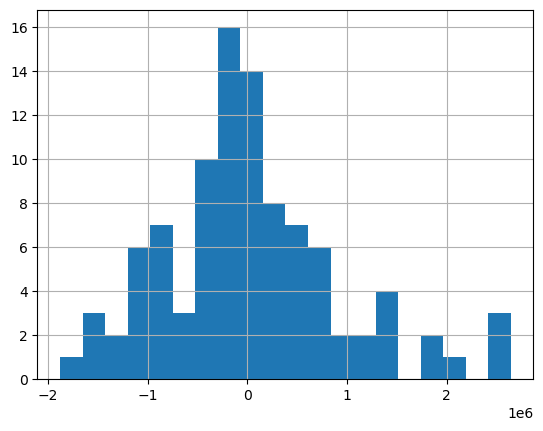

In [79]:
(y_test - y_pred).hist(bins=20)

<Axes: xlabel='price', ylabel='price'>

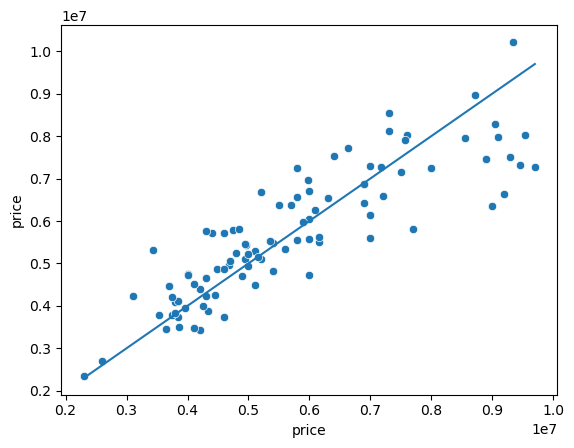

In [80]:
import seaborn as sns

sns.scatterplot(x=y_test,y=y_pred)
sns.lineplot(x=y_test, y=y_test)

In [81]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test,y_pred)

0.11381266144926591

In [82]:
y_pred_train = grid.best_estimator_.predict(X_train)

In [83]:
mean_absolute_percentage_error(y_train, y_pred_train)

0.1129108674910948

<Axes: xlabel='price', ylabel='price'>

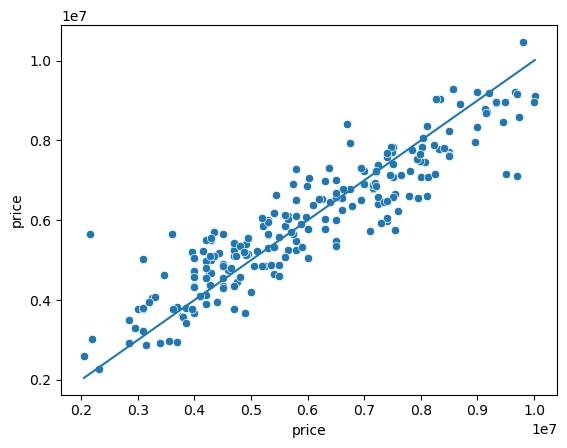

In [84]:
sns.scatterplot(x=y_train,y=y_pred_train)
sns.lineplot(x=y_train, y=y_train)

### Задания 
1. Сохранить полученную модель и использовать ее для реализации приложения streamlit. 
2. Попробовать другие способы борьбы с сдвигом (недообучением) модели.

In [86]:
import pickle

# save the model as a pickle file
model_pkl_file = "apartment_prices_regression.pkl"

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(pipe, file)